Movie Recomandation 

I want to develop an alghoritm where i recommend movies based on previous watches and rating for a specific user

First step : scraping the data from letterboxd

Second step : Applying Singular Value Decomposition for getting Movie Recommandations

In [1]:
from bs4 import BeautifulSoup #for scraping data 
import requests #for scraping data
import pandas as pd # for creating dataframes 
import numpy as np
from matplotlib import pyplot as plt # to show 
from scipy.sparse.linalg import svds #svd algorithm used 
from csv import writer

DOMAIN = "https://letterboxd.com" # the site im going to get my data of movies



Scraping the data of my user

In [2]:
username = "/wracat/"
url = DOMAIN + username + "films/"
url_page = requests.get(url)
soup = BeautifulSoup(url_page.content, 'html.parser')

As i don't get my data to look nice in this format, i would put it in a html file to view it better

In [3]:
html_filename = "mydata.html"

with open(html_filename, 'w', encoding='utf-8') as html_file:
    html_file.write(soup.prettify())

print(f"Data has been written to {html_filename}")

Data has been written to mydata.html


As i scroll down in mydata.html i can see that my logged films are written in 
<ul class="poster-list -p70 -grid film-list clear">
inside this
<li class="poster-container">
also the name of the film would be the alt of this image source 
<img alt="Saw X" class="image" height="105" src="https://s.ltrbxd.com/static/img/empty-poster-70.8112b435.png" width="70"/>

and the rating i give it in : <p class="poster-viewingdata">
if it's liked, it would appear this <p class="poster-viewingdata -rated-and-liked">
the rating would be made of ***** and if it is a half star it would be signal as 1/2

Now i am gonna take that data into an array

Also before i do my scraping i have to take in account pagination to get all my data correctly
that i found in <li class="paginate-page">

In [63]:
paginate = soup.find_all("li","paginate-page")

for i in range(len(paginate)):
    url = DOMAIN + "/" + username + "/films/page/" + str(i+1)
    url_page = requests.get(url)
    soup = BeautifulSoup(url_page.content, 'html.parser')
    ul = soup.find("ul", {"class": "poster-list"})
    if (ul != None):
      movies = ul.find_all("li")
print(movies[0])

<li class="poster-container">
<div class="really-lazy-load poster film-poster film-poster-42428 linked-film-poster" data-cache-busting-key="80a3e65c" data-film-id="42428" data-film-slug="the-cat-returns" data-image-height="105" data-image-width="70" data-linked="linked" data-poster-url="/film/the-cat-returns/image-150/" data-show-menu="true" data-target-link="/film/the-cat-returns/" data-target-link-target=""> <img alt="The Cat Returns" class="image" height="105" src="https://s.ltrbxd.com/static/img/empty-poster-70.8112b435.png" width="70"/> <span class="frame"><span class="frame-title"></span></span> </div> <p class="poster-viewingdata"> <span class="rating -tiny -darker rated-8">★★★★</span> </p>
</li>


In [4]:
#i have to take in account the rating and to convert them from stars to actual numbers 
def rating(star):
    stars={
        "★": 1,
        "★★": 2,
        "★★★": 3,
        "★★★★": 4,
        "★★★★★": 5,
        "½": 0.5,
        "★½": 1.5,
        "★★½": 2.5,
        "★★★½": 3.5,
        "★★★★½": 4.5
    }
    try:
        return stars[star]
    except:
        return 0



Now i can start scraping and for that i would do a specific function for it because i want to scrape more data. And i have to take in account alsoo that i get raw data from mydata.html

In [5]:
def scraping_data(username):
    dict_movies = {}
    dict_movies['id']=[]
    dict_movies['title'] = []
    dict_movies['rating'] = []
    url = DOMAIN + username + "films/"
    url_page = requests.get(url)
    soup = BeautifulSoup(url_page.content, 'html.parser')

    # now i start scraping
    paginate = soup.find_all("li","paginate-page")
    filtred_paginate_number = 1
    if paginate:
        filtred_paginate_number = min(int(paginate[-1].find('a').get_text().strip()),17)
    for i in range(filtred_paginate_number):
        url = DOMAIN + "/" + username + "/films/by/popular/page/" + str(i+1)
        url_page = requests.get(url)
        soup = BeautifulSoup(url_page.content, 'html.parser')
        ul = soup.find("ul", {"class": "poster-list"})
        if (ul != None):
            movies = ul.find_all("li")
            for movie in movies:
                dict_movies['id'].append(movie.find('div')['data-film-id'])
                dict_movies['title'].append(movie.find('img')['alt'])
                dict_movies['rating'].append(rating(movie.find('p', {"class": "poster-viewingdata"}).get_text().strip()))
        #i transform the data into pandas to get to manipulate the data more easely
    df_movie = pd.DataFrame(dict_movies)
    return df_movie
# my_movies = scraping_data("/cosmonautmarkie/")
# print(my_movies.shape)

    

Scrap the username of the first 600 most popular users

In [6]:
def scraping_popular_users():
    popular_users=[]
    url = DOMAIN + "/members/popular/this/all-time/"
    url_page = requests.get(url)
    soup = BeautifulSoup(url_page.content, 'html.parser')
    
    # html_filename = "popularusers.html"
    # with open(html_filename, 'w', encoding='utf-8') as html_file:
    #     html_file.write(soup.prettify())
    
    paginate_number = 20
    i = 1
    for i in range(paginate_number):
        url = DOMAIN + "/members/popular/this/all-time/page/"+str(i)
        url_page = requests.get(url)
        soup = BeautifulSoup(url_page.content, 'html.parser')
        tbody = soup.find("tbody")
        if(tbody!=None):
            names = soup.find_all("td", {"class":"table-person"})
            for name in names:
                popular_users.append(name.find('a')['href'])
    return popular_users
# popular_users = scraping_popular_users()
# print(popular_users)


get a Data Frame of the ratings of the 600 most popular users

In [7]:
def getUserRatingsdataFrame(popular_users):
    users = []
    
    for popular_user in popular_users:
        scrapped_user = scraping_data(popular_user)
        print(popular_user)
        if isinstance(scrapped_user, pd.DataFrame):
            for index, user in scrapped_user.iterrows():
                user_data = {
                    'name': popular_user,
                    'filmId': user['id'],
                    'title': user['title'],
                    'rating': user['rating']
                }
                users.append(user_data)

    df_users = pd.DataFrame(users)
    return df_users

# users_db = getUserRatingsdataFrame(popular_users)
# users_db.to_csv('users_db.csv', index=False)



Creating Moviedatabase

In [8]:
#for this part i would take the popular_users films and create a dataframe for the movies
def create_popular_users_movie(popular_users):
    dict_movie = {}
    dict_movie['filmId'] = []
    dict_movie['title'] = []

    for index,row in popular_users.iterrows(): 
        movie_id = row['filmId']

        if movie_id not in dict_movie['filmId']:
            dict_movie['filmId'].append(movie_id)
            dict_movie['title'].append(row['title'])

    df_movie = pd.DataFrame(dict_movie)
    return df_movie

# movie_db = create_popular_users_movie(users_db)
# movie_db.to_csv('movie_db.csv', index = False)
# movie_db.head()


In [10]:
users_db = pd.read_csv("users_db.csv")
movie_db = pd.read_csv("movie_db.csv")

First print average ratings per user

(688612, 4)


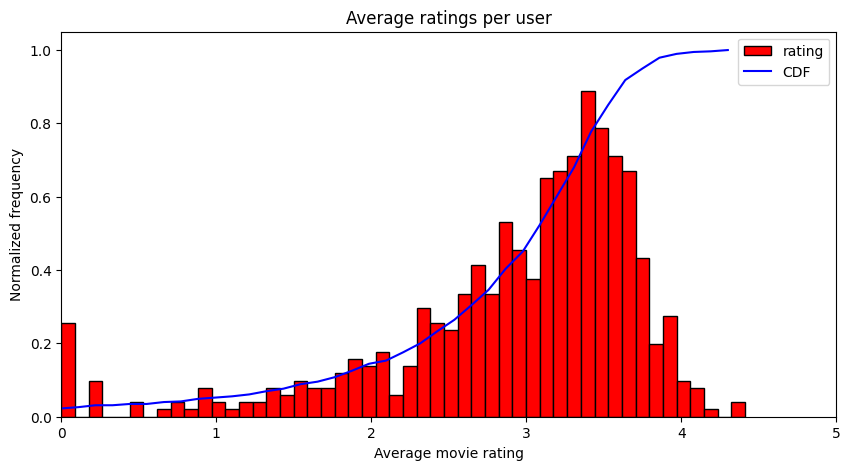

In [11]:

dftmp = users_db[['name','rating']].groupby('name').mean()
print(users_db.shape)
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, density=True, color='red', edgecolor='black', figsize=(10,5))

# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, density=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()



Ratings per movie


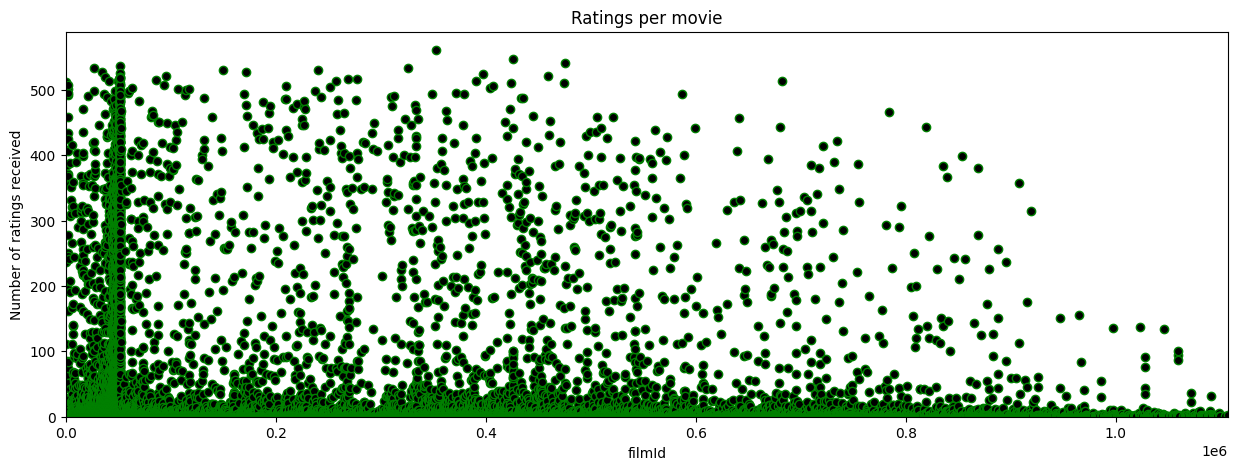

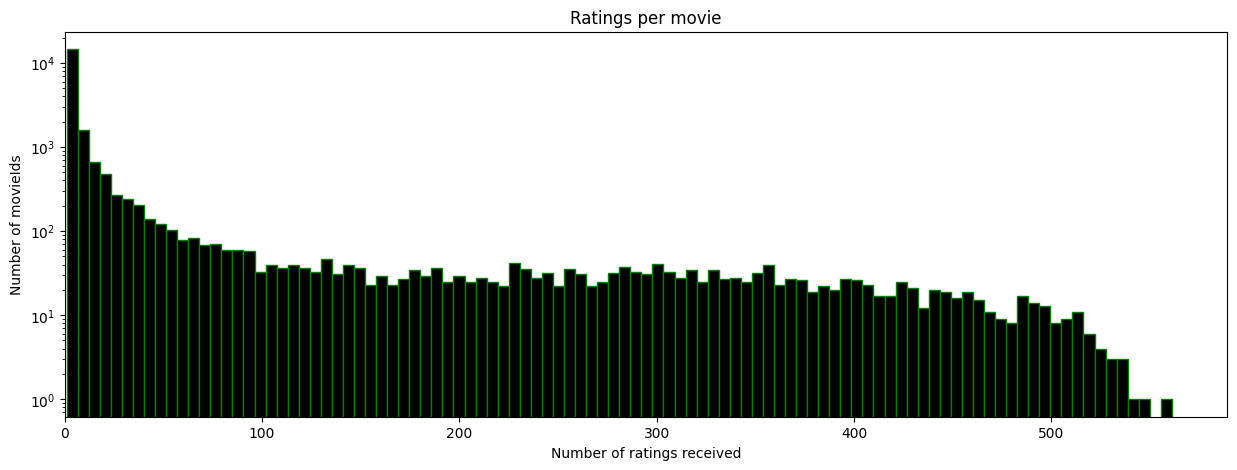

In [12]:
dftmp = users_db[['name', 'filmId']].groupby('filmId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='green', color = 'black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('filmId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='green', color = 'black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()


# Housekeeping
%reset_selective -f (^dftmp$|^tmp$)

WordCloud Visualization for Movie Title

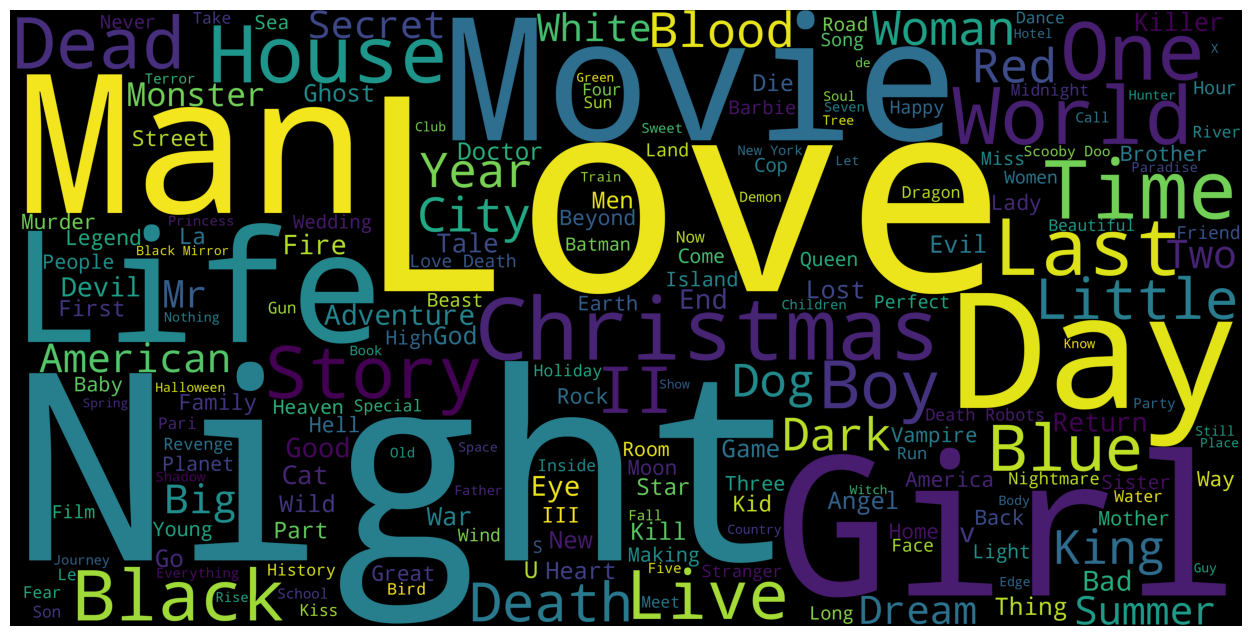

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Create a wordcloud of the movie titles
movie_db = pd.read_csv("movie_db.csv")
movie_db['title'] = movie_db['title'].fillna("").astype('str')
title_corpus = ' '.join(movie_db['title'])

# Use WordCloud without specifying font_path and set the default font
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, prefer_horizontal=1.0).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Create a User-Item Matrix

In [14]:
users_db = pd.read_csv('users_db.csv')
movie_db = pd.read_csv('movie_db.csv')
def user_item_matrix(movie_db,users_db):
    merged_df = pd.merge(users_db, movie_db, on=['filmId', 'title'], how='inner')
    user_item_matrix = pd.pivot_table(merged_df, values='rating', index='name', columns='title', fill_value=0)

    # Calculate the number of reviews for each movie
    reviews_per_movie = user_item_matrix.sum(axis=0)

    # Select movies with more than 100 reviews
    selected_movies = reviews_per_movie[reviews_per_movie > 100].index

    # Filter the user_item_matrix based on selected movies
    filtered_user_item_matrix = user_item_matrix[selected_movies]

    # Save the filtered matrix to a new CSV file
    filtered_user_item_matrix.to_csv('filtered_user_item_matrix.csv')
    return filtered_user_item_matrix
# filtered_user_item_matrix=user_item_matrix(movie_db,users_db)
# print(filtered_user_item_matrix.shape)
# R=filtered_user_item_matrix.to_numpy()

Find the sparsity Level

In [15]:
filtered_user_item_matrix = user_item_matrix(movie_db,users_db)
R = filtered_user_item_matrix.to_numpy()
total_values = R.size
missing_values = np.count_nonzero(R)  # Count the number of zeros (missing values)
print(missing_values)
print(total_values)
sparsity = missing_values / total_values
print("Sparsity of the user-item matrix:", (1-sparsity)*100 ,"%")

476276
1604250
Sparsity of the user-item matrix: 70.31160978650459 %


Writing Svd Alghoritm

In [16]:
def custom_svd(A, k=None):
    # Calculate Vt
    W_vt = np.dot(A.T, A)
    eigenvalues_vt, vt = np.linalg.eig(W_vt)
    ncols_vt = np.argsort(eigenvalues_vt)[::-1]
    
    if k is not None:
        ncols_vt = ncols_vt[:k]

    Vt = vt[:, ncols_vt].T

    # Calculate U
    W_u = np.dot(A, A.T)
    eigenvalues_u, u = np.linalg.eig(W_u)
    ncols_u = np.argsort(eigenvalues_u)[::-1]

    if k is not None:
        ncols_u = ncols_u[:k]

    U = u[:, ncols_u]

    # Calculate Sigma
    if np.size(W_vt) > np.size(W_u):
        Sigma = W_vt
    else:
        Sigma = W_u
    
    eigenvalues_sigma, _ = np.linalg.eig(Sigma)
    eigenvalues_sigma = np.sqrt(eigenvalues_sigma)
    
    if k is not None:
        eigenvalues_sigma = eigenvalues_sigma[:k]

    Sigma = np.diag(eigenvalues_sigma[::-1])

    return U, Sigma, Vt

Setting up SVD

In [17]:
def performing_svd(R):
    user_ratings_mean = np.mean(R, axis = 1, keepdims=True) # calculating average rating by user
    normalized_R = R - user_ratings_mean ## Normalize matrix R

    U,Sigma,Vt = svds(normalized_R, k = 50)
    # custom_U,custom_Sigma,custom_Vt=custom_svd(normalized_R,50)
    sigma_diag_matrix=np.diag(Sigma)
    return U,sigma_diag_matrix,Vt,user_ratings_mean



Visualising Data

1) Examine the explained variance by the singular values in Sigma to understand how much information each latent factor contributes to the overall variance in the dataset.
Explained Variance_ratio = sigma_value^2 / Sum(sigma)

In [20]:
explained_variance = np.cumsum(svds.explained_variance_ratio_)

# Plot explained variance
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

AttributeError: 'function' object has no attribute 'explained_variance_ratio_'

Visualizing the latent factors (U,Vt) can give you insights into the relationships between users and items

U interpretation -> Each point in the scatter plot represents a user in the space defined by the first two latent factors.
The position of users in this space is determined by their relationships with these latent factors.
Users with similar patterns of interactions will be closer in this space.

Vt interpretation -> Each point in the scatter plot represents movie in the space

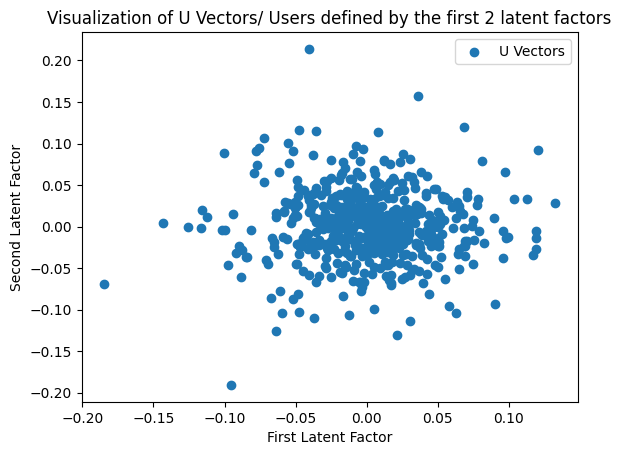

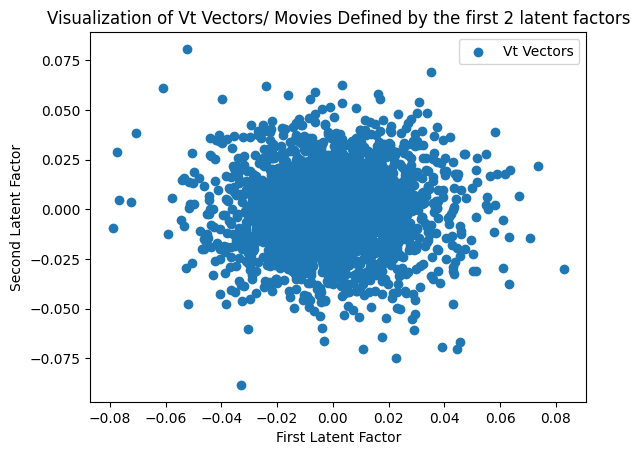

In [21]:
# Plot U vectors
U,Sigma,Vt,mean = performing_svd(R)
plt.scatter(U[:, 0], U[:, 1], label='U Vectors')
plt.xlabel('First Latent Factor')
plt.ylabel('Second Latent Factor')
plt.title('Visualization of U Vectors/ Users defined by the first 2 latent factors')
plt.legend()
plt.show()

# Plot Vt vectors
plt.scatter(Vt[0, :], Vt[1, :], label='Vt Vectors')
plt.xlabel('First Latent Factor')
plt.ylabel('Second Latent Factor')
plt.title('Visualization of Vt Vectors/ Movies Defined by the first 2 latent factors')
plt.legend()
plt.show()


How movies contribute to each latent factor

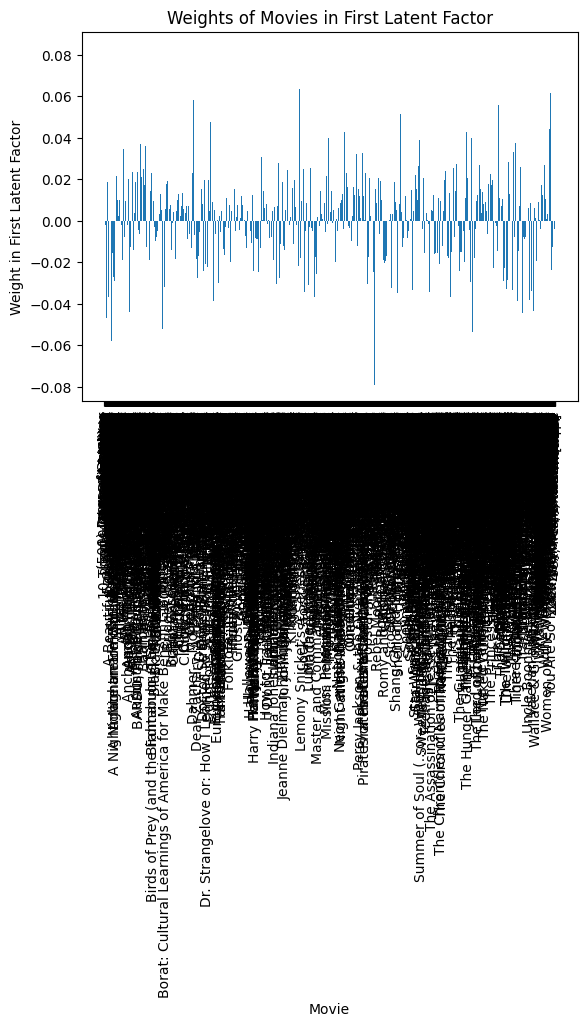

In [22]:
# Get movie names from columns of the user-item matrix
movie_names = filtered_user_item_matrix.columns

# Plot weights of the first latent factor or each movie 
plt.bar(movie_names, Vt[0, :])
plt.xticks(rotation=90)
plt.xlabel('Movie')
plt.ylabel('Weight in First Latent Factor')
plt.title('Weights of Movies in First Latent Factor')
plt.show()

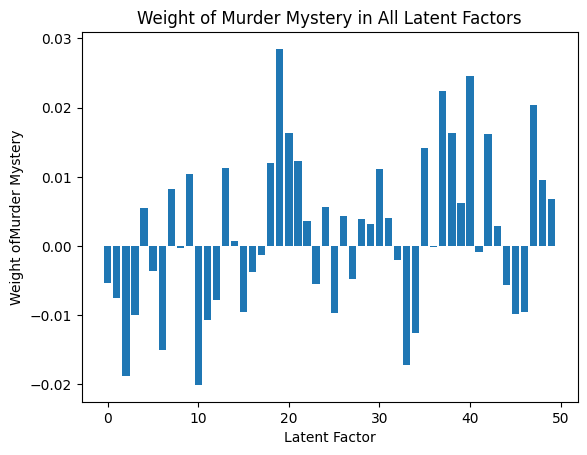

In [23]:

movie_name = np.random.choice(movie_names)
movie_name_index = np.where(movie_names == movie_name)[0][0]

# Plot the weight of movie_name in all latent factors
plt.bar(range(len(Vt[:, movie_name_index])), Vt[:, movie_name_index])
plt.xlabel('Latent Factor')
plt.ylabel('Weight of' + movie_name)
plt.title("Weight of " + movie_name + " in All Latent Factors")
plt.show()


Reconsituirea matricei dupa SVD - > Making Predictions

In [24]:
#Making Predicted Rating matrix where i return the matrix resulted through recomposition
def predicted_ratings(U,sigma,Vt,mean):

    predicted_ratings = np.dot(np.dot(U, sigma), Vt) + mean
    # custom_predicted_ratings = np.dot(np.dot(custom_U,custom_Sigma),custom_Vt) + user_ratings_mean
    # print(predicted_ratings.shape)

    # Create a DataFrame from the predicted ratings
    predicted_df = pd.DataFrame(predicted_ratings, index=filtered_user_item_matrix.index, columns=filtered_user_item_matrix.columns)
    # custom_predicted_df = pd.DataFrame(custom_predicted_ratings, index=filtered_user_item_matrix.index, columns=filtered_user_item_matrix.columns)

    predicted_df.to_csv("predicted.csv")


    # Compute the Frobenius norm of the original matrix
    norm_original = np.linalg.norm(R, 'fro')

    # Compute the Frobenius norm of the difference between original and reconstructed matrix
    norm_difference = np.linalg.norm(R - predicted_ratings, 'fro')

    # Calculate the relative error
    relative_error = norm_difference / norm_original

    # print(f'Relative Error: {relative_error}')
    return predicted_df

# print("Predicted Data")
# print(predicted_df)


Making Predictions for Users from My Database

In [25]:

# Choose a random user index
def userPredicted(predicted_df,user_index,filtered_user_item_matrix):
    # Get the user's ratings and predicted ratings
    user_ratings = filtered_user_item_matrix.iloc[user_index]
    user_predictions = predicted_df.iloc[user_index]

    # Get rated movies
    rated_movies = user_ratings[user_ratings != 0].index

    # Sort movies by predicted rating in descending order, excluding rated movies
    recommended_movies = user_predictions.drop(rated_movies).sort_values(ascending=False)

    # Display user ratings, unrated movies, and recommended movies
    # print("User Ratings:")
    # print(user_ratings)
    # print("\Rated Movies:")
    # print(rated_movies)
    print("\nRecommended Movies:")
    print(recommended_movies.head())


# print(f"Prediction using custom svd\n\n")
# predicted_ratings(custom_predicted_df,user_index)


Getting predictions for random users in my data set

In [26]:
filtered_user_item_matrix=user_item_matrix(movie_db,users_db)
R=filtered_user_item_matrix.to_numpy()
U,sigma,Vt,mean = performing_svd(R)
predicted_df = predicted_ratings(U,sigma,Vt,mean)

user_index = np.random.randint(min(filtered_user_item_matrix.shape) - 1)

print(f"Prediction using svd from import\n\n")
userPredicted(predicted_df,user_index,filtered_user_item_matrix)

Prediction using svd from import



Recommended Movies:
title
Rosemary's Baby       4.472511
Spencer               3.809877
Dogville              3.619503
Dancer in the Dark    3.554866
Skyfall               3.517495
Name: /leeyim/, dtype: float64


Making predictions from any user on letterboxd

In [27]:

# Setting up data username data to users_db and movie_db
def getting_data_to_db(username):
    username_movie_data = scraping_data(username)
    username_movie_data.shape
    username_data=[]

    for index, user in username_movie_data.iterrows():
        data = {
            'name':username,
            'filmId': user['id'],
            'title': user['title'],
            'rating': user['rating']
            }
        username_data.append(data)
    df_username_data = pd.DataFrame(username_data)

    df_username_data.to_csv('users_db.csv',mode='a', index=False,header=False)

    # append new movies to movies_db
    dict_movie = {}
    dict_movie['filmId'] = []
    dict_movie['title'] = []
    movie_db = pd.read_csv("movie_db.csv")

    i = 0
    for index,row in df_username_data.iterrows(): 
        movie_id = row['filmId']
        if int(movie_id) not in movie_db['filmId'].values:
            dict_movie['filmId'].append(movie_id)
            dict_movie['title'].append(row['title'])

    df_movie = pd.DataFrame(dict_movie)
    updated_movie_db = pd.concat([movie_db, df_movie], ignore_index=True)

    # Save the updated movie_db 
    updated_movie_db.to_csv('movie_db.csv', index=False)

    #ensure to start from a new row
    # with open("movie_db.csv", 'a') as file:
    #     file.write('\n')
    # with open("users_db.csv", 'a') as file:
    #     file.write('\n')


Getting the new filtred item matrix 

In [35]:

username="matei_alexandru"
username= "/"+username+"/"

users_db = pd.read_csv("users_db.csv")

if username not in users_db['name'].values:
    getting_data_to_db(username)
    users_db = pd.read_csv("users_db.csv")

movie_db = pd.read_csv("movie_db.csv")

filtered_user_item_matrix=user_item_matrix(movie_db,users_db)

R=filtered_user_item_matrix.to_numpy()
U,sigma,Vt,mean = performing_svd(R)

predicted_df = predicted_ratings(U,sigma,Vt,mean)

user_index = filtered_user_item_matrix.index.get_loc(username)

userPredicted(predicted_df,user_index,filtered_user_item_matrix)

